## CUQIpy component final project

**Note: under construction to be finalized by midnight 21 July 2024** 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# import cuqi
from cuqi.model import Model #, LinearModel
from cuqi.geometry import MappedGeometry, Continuous1D, KLExpansion #, Geometry, Continuous
from cuqi.distribution import Gaussian

from testBeam import BeamModel1D
from hydraulic import hydraulic_class

- Create a mapped KL expansion domain geometry with the mapping `lambda x: exp(x)`.
- Create a continuous range geometry for the range.
- Create a user define CUQIpy model representing the forward model (hydraulic).
- Create a Gaussian i.i.d. prior
- Create a Gaussian likelihood (for one injection pattern)
- Create a synthetic data from the given true porosity.
- Create a posterior
- Use MH for sampling
- Use NUTS for sampling
- Compare the results (ess, pair_plot, trace_plot, plot_ci)
- Comment on the computational cost of nuts (tree size, FD)
- Create a posterior with multiple likelihoods (for multiple injection patterns)
- Use MH for sampling
- Comment on how adding more data helped the inference.



[-1.03598331e-239 -1.93543441e-239 -2.72082411e-239 -3.40432650e-239
 -3.99029208e-239 -4.48155655e-239 -4.87957440e-239 -5.18290204e-239
 -5.38861804e-239 -5.49348444e-239]
[0.         0.         0.         0.02793295 0.00816993 0.01521813
 0.05487925 0.03003205 0.02744186 0.08134957 0.06310457 0.03766599
 0.10767686 0.10564416 0.04638403 0.13400892 0.15623331 0.05376485
 0.1605006  0.21359203 0.05991419 0.18732973 0.27651894 0.06488211
 0.21459154 0.34380376 0.0686051  0.24232488 0.41413969 0.07095682
 0.27059974 0.48608293 0.07178755]
Plotting 5 randomly selected samples


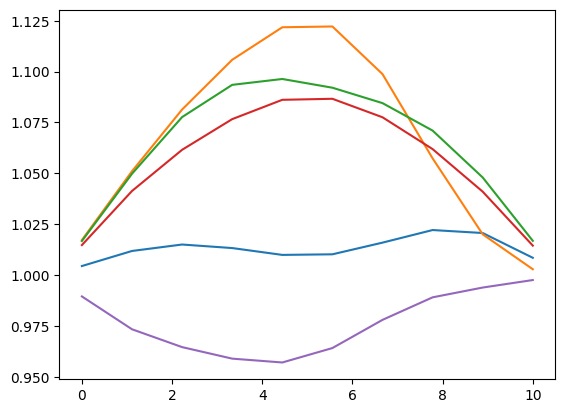

In [4]:
# Data and initialization
t = lambda X: np.exp(X)             # Define mapping
L = 10                               # domain length 1
N_points = 10                       # Number of discretization points
N_modes = 5                         # Number of terms in KL expansion
grid1 = np.linspace(0,L,N_points)   # Discretization for domain

# Create Beam and hydrolic models
model_hydrolic = Model(forward=hydraulic_class(N=N_points, L=L).forward, 
                       range_geometry=Continuous1D(grid=grid1),
                       domain_geometry=MappedGeometry(KLExpansion( grid=grid1,num_modes=N_modes ), map = t))

model_Beam = Model(forward=BeamModel1D(nelx=N_points, Lx=L).forward, 
                   range_geometry=Continuous1D(grid=grid1),
                   domain_geometry=MappedGeometry(KLExpansion(grid=grid1,
                                                              num_modes=N_modes), 
                                                              map = t))


# Test both mdoels for som input
print(model_hydrolic(np.ones(5)))
print(model_Beam(np.ones(5)))

# Gaussian prior -> test it on beam domain
prior = Gaussian(0, 1, geometry=model_Beam.domain_geometry);
prior.sample(100).plot();